In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "../Dataset"

train_path = data_path+'/Train'
test_path = data_path+'/Test'

train_horses_path = train_path+'/horses'
test_horses_path = test_path+'/horses'

train_humans_path = train_path+'/humans'
test_humans_path = test_path+'/humans'

Check if dataset is balanced

In [3]:
train_images_qty = len(os.listdir(train_horses_path)),len(os.listdir(train_humans_path))
print('Number of samples per class in training dataset: (Horses, Humans) -> '+str(train_images_qty))
if (abs(1-train_images_qty[0]/train_images_qty[1]) > 0.2):
    print('Training set is not balanced, needs over or undersampling')
else:
    print('Training set is balanced!')

Number of samples per class in training dataset: (Horses, Humans) -> (500, 527)
Training set is balanced!


In [4]:
test_images_qty = len(os.listdir(test_horses_path)),len(os.listdir(test_humans_path))
print('Number of samples per class in testing dataset: (Horses, Humans) -> '+str(test_images_qty))
if (abs(1-train_images_qty[0]/train_images_qty[1]) > 0.2):
    print('Testing set is not balanced, needs over or undersampling')
else:
    print('Testing set is balanced!')

Number of samples per class in testing dataset: (Horses, Humans) -> (128, 128)
Testing set is balanced!


Plot samples

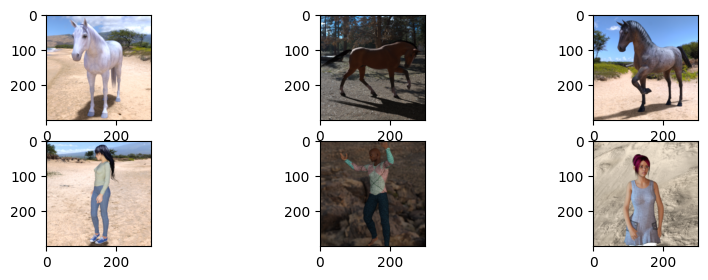

In [5]:
horse_smp = []
human_smp = []

for i in range(3):
    horse_im = Image.open(train_horses_path+'/'+os.listdir(train_horses_path)[i*100])
    human_im = Image.open(train_humans_path+'/'+os.listdir(train_humans_path)[i*100])
    horse_smp.append(horse_im)
    human_smp.append(human_im)   

plt.rcParams["figure.figsize"] = (10,3)
fig, axs = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        if i == 0:
            axs[i, j].imshow(horse_smp[j])
        else:
            axs[i, j].imshow(human_smp[j])
plt.show()

Preprocessing

In [6]:
def pre_process(img_size, convert_to_grayscale, root_path, target):
    preprocessed_dataset = []
    label=[]
    folder_path = root_path+'/'+target

    for i in os.listdir(folder_path):
        preprocessed_img = Image.open(folder_path + "/" + i)
        if convert_to_grayscale:
            preprocessed_img = preprocessed_img.convert("L") # converting grey scale 
        preprocessed_img = preprocessed_img.resize((img_size,img_size), Image.ANTIALIAS) # resizing to 50,50
        preprocessed_img = np.asarray(preprocessed_img)/255 # bit format
        preprocessed_dataset.append(preprocessed_img)
        if target=='humans':
            label.append(1)
        else:
            label.append(0)

    return preprocessed_dataset, label

In [7]:
humans_train, humans_train_label = pre_process(img_size=50, convert_to_grayscale=True, root_path=train_path, target='humans')
horses_train, horses_train_label = pre_process(img_size=50, convert_to_grayscale=True, root_path=train_path, target='horses')

train_dataset = np.asarray(humans_train+horses_train)
train_label= np.asarray(humans_train_label+horses_train_label).reshape(-1, 1)

humans_test, humans_test_label = pre_process(img_size=50, convert_to_grayscale=True, root_path=test_path, target='humans')
horses_test, horses_test_label = pre_process(img_size=50, convert_to_grayscale=True, root_path=test_path, target='horses')

test_dataset = np.asarray(humans_test+horses_test)
test_label=np.asarray(humans_test_label+horses_test_label).reshape(-1, 1)

print("Preprocessed Train Dataset Size:",np.shape(train_dataset), "Preprocessed Train label Size:",np.shape(train_label))
print("Preprocessed Test Dataset Size:",np.shape(test_dataset), "Preprocessed Test label Size:",np.shape(test_label))

Preprocessed Train Dataset Size: (1027, 50, 50) Preprocessed Train label Size: (1027, 1)
Preprocessed Test Dataset Size: (256, 50, 50) Preprocessed Test label Size: (256, 1)


In [8]:
train_dataset_reshaped = train_dataset.reshape(train_dataset.shape[0],train_dataset.shape[1]*train_dataset.shape[2])
test_dataset_reshaped = test_dataset.reshape(test_dataset.shape[0],test_dataset.shape[1]*test_dataset.shape[2])

print("Reshaped Preprocessed Train Dataset Size:",np.shape(train_dataset_reshaped))
print("Reshaped Preprocessed Test Dataset Size:",np.shape(test_dataset_reshaped))

Reshaped Preprocessed Train Dataset Size: (1027, 2500)
Reshaped Preprocessed Test Dataset Size: (256, 2500)


In [9]:
x_train = train_dataset_reshaped
x_test = test_dataset_reshaped
y_train = train_label
y_test = test_label

print("Final preprocessed images for training :",np.shape(x_train))
print("Final preprocessed labels for training :",np.shape(x_test))
print("Final preprocessed images for testing :",np.shape(y_train))
print("Final preprocessed labels for testing :",np.shape(y_test))

Final preprocessed images for training : (1027, 2500)
Final preprocessed labels for training : (256, 2500)
Final preprocessed images for testing : (1027, 1)
Final preprocessed labels for testing : (256, 1)


Experimenting Classic Machine Learning models

In [10]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [11]:
# Logistic Regressor with Grid Search and Kfold=5

lg_grid = {
    "C": np.logspace(-4, 4, 20),
    "penalty": ["l1","l2"]
}
lg=LogisticRegression(solver='liblinear', random_state=42)

log_reg_cv=GridSearchCV(lg,lg_grid,cv=5,n_jobs=10,verbose=2)
log_reg_cv.fit(x_train,y_train)
print("Accuracy in train dataset with Logistic Regressor: ", log_reg_cv.best_score_)

best_lg_cv = log_reg_cv.best_estimator_
y_pred_lg_cv = best_lg_cv.predict(x_test)
test_accuracy_lg_cv = accuracy_score(y_test, y_pred_lg_cv)

print("Accuracy in test dataset with Logistic Regressor: ", test_accuracy_lg_cv)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Accuracy in train dataset with Logistic Regressor:  0.7138195595548188
Accuracy in test dataset with Logistic Regressor:  0.80078125


In [12]:
# Logistic Regressor with Grid Search and Stratified Kfold=5

lg_grid = {
    "C": np.logspace(-4, 4, 20),
    "penalty": ["l1","l2"]
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lg=LogisticRegression(solver='liblinear', random_state=42)

log_reg_cv_strat_kfold=GridSearchCV(lg,lg_grid,cv=kfold,n_jobs=10,verbose=2)
log_reg_cv_strat_kfold.fit(x_train,y_train)
print("Accuracy in train dataset with Logistic Regressor + Stratified Kfold: ", log_reg_cv_strat_kfold.best_score_)

best_lg_cv_strat_kfold = log_reg_cv_strat_kfold.best_estimator_
y_pred_lg_cv_strat_kfold = best_lg_cv_strat_kfold.predict(x_test)
test_accuracy_lg_cv_strat_kfold = accuracy_score(y_test, y_pred_lg_cv_strat_kfold)

print("Accuracy in test dataset with Logistic Regressor + Stratified Kfold: ", test_accuracy_lg_cv_strat_kfold)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Accuracy in train dataset with Logistic Regressor + Stratified Kfold:  0.9065593180203647
Accuracy in test dataset with Logistic Regressor + Stratified Kfold:  0.80078125


In [13]:
# Random Forest with Grid Search and Kfold=5

rf_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(estimator=rf,param_grid=rf_grid,cv=5,n_jobs=10,verbose=2)
rf_cv.fit(x_train, y_train) 
print("Accuracy in train dataset with Random Frest: ", rf_cv.best_score_)

best_rf_cv = rf_cv.best_estimator_
y_pred_rf_cv = best_rf_cv.predict(x_test)
test_accuracy_rf_cv = accuracy_score(y_test, y_pred_rf_cv)

print("Accuracy in test dataset with Random Frest: ", test_accuracy_rf_cv)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Accuracy in train dataset with Random Frest:  0.7674260004735969
Accuracy in test dataset with Random Frest:  0.82421875


In [14]:
# Random Forest with Grid Search and and Stratified Kfold=5

rf_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10]
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42)
rf_cv_strat_kfold = GridSearchCV(estimator=rf,param_grid=rf_grid,cv=kfold,n_jobs=10,verbose=2)
rf_cv_strat_kfold.fit(x_train, y_train) 
print("Accuracy in train dataset with Random Frest + Stratified Kfold: ", rf_cv_strat_kfold.best_score_)

best_rf_cv_strat_kfold = rf_cv_strat_kfold.best_estimator_
y_pred_rf_cv_strat_kfold = best_rf_cv_strat_kfold.predict(x_test)
test_accuracy_rf_cv_strat_kfold = accuracy_score(y_test, y_pred_rf_cv_strat_kfold)

print("Accuracy in test dataset with Random Frest + Stratified Kfold: ", test_accuracy_rf_cv_strat_kfold)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Accuracy in train dataset with Random Frest + Stratified Kfold:  0.969817665166943
Accuracy in test dataset with Random Frest + Stratified Kfold:  0.57421875


In [15]:
#Since the model had an overfit, will change grid search
#with parameters based in the first random forest that performed better
print("Best params from simple random Forest: ", rf_cv.best_params_)

Best params from simple random Forest:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


In [16]:
# Random Forest with optimized Grid Search params and Stratified Kfold=5
rf_grid = {
    "n_estimators": [100, 300],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5]
}
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42)
rf_cv_strat_kfold = GridSearchCV(estimator=rf,param_grid=rf_grid,cv=kfold,n_jobs=10,verbose=2)
rf_cv_strat_kfold.fit(x_train, y_train) 
print("Accuracy in train dataset with Random Frest + Stratified Kfold: ", rf_cv_strat_kfold.best_score_)

best_rf_cv_strat_kfold = rf_cv_strat_kfold.best_estimator_
y_pred_rf_cv_strat_kfold = best_rf_cv_strat_kfold.predict(x_test)
test_accuracy_rf_cv_strat_kfold = accuracy_score(y_test, y_pred_rf_cv_strat_kfold)

print("Accuracy in test dataset with Random Frest + Stratified Kfold: ", test_accuracy_rf_cv_strat_kfold)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Accuracy in train dataset with Random Frest + Stratified Kfold:  0.9678675145914672
Accuracy in test dataset with Random Frest + Stratified Kfold:  0.87109375


Experimenting Neural Network (Deep Learning) Models

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed

In [18]:
#Preprocessing for CNN

train_dataset_reshaped_cnn = np.asarray(train_dataset).reshape(-1, 50, 50, 1)
test_dataset_reshaped_cnn = np.asarray(test_dataset).reshape(-1, 50, 50, 1)

train_label_reshaped_cnn = np.asarray(humans_train_label+horses_train_label)
test_label_reshaped_cnn = np.asarray(humans_test_label+horses_test_label)

print("Preprocessed Train Dataset Size:",np.shape(train_dataset_reshaped_cnn), "Preprocessed Train label Size:",np.shape(train_label_reshaped_cnn))
print("Preprocessed Test Dataset Size:",np.shape(test_dataset_reshaped_cnn), "Preprocessed Test label Size:",np.shape(test_label_reshaped_cnn))

Preprocessed Train Dataset Size: (1027, 50, 50, 1) Preprocessed Train label Size: (1027,)
Preprocessed Test Dataset Size: (256, 50, 50, 1) Preprocessed Test label Size: (256,)


In [19]:
X = train_dataset_reshaped_cnn
y = train_label_reshaped_cnn
np.random.seed(42)
set_seed(42)

In [20]:
def build_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
#Testing basic CNN model

cnn_model = build_cnn()
cnn_model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
loss, accuracy = cnn_model.evaluate(test_dataset_reshaped_cnn, test_label_reshaped_cnn)
print(f"\nTest Accuracy: {accuracy:.4f}")

Epoch 1/10
29/29 [==============================] - 4s 75ms/step - loss: 0.5745 - accuracy: 0.6916 - val_loss: 0.5085 - val_accuracy: 0.7864
Epoch 2/10
29/29 [==============================] - 2s 68ms/step - loss: 0.2329 - accuracy: 0.9167 - val_loss: 1.1435 - val_accuracy: 0.5243
Epoch 3/10
29/29 [==============================] - 2s 67ms/step - loss: 0.1524 - accuracy: 0.9470 - val_loss: 0.6644 - val_accuracy: 0.7670
Epoch 4/10
29/29 [==============================] - 2s 67ms/step - loss: 0.1176 - accuracy: 0.9567 - val_loss: 0.7328 - val_accuracy: 0.7767
Epoch 5/10
29/29 [==============================] - 2s 65ms/step - loss: 0.0633 - accuracy: 0.9827 - val_loss: 1.2606 - val_accuracy: 0.5922
Epoch 6/10
29/29 [==============================] - 2s 73ms/step - loss: 0.0431 - accuracy: 0.9946 - val_loss: 1.0341 - val_accuracy: 0.7282
Epoch 7/10
29/29 [==============================] - 2s 76ms/step - loss: 0.0361 - accuracy: 0.9892 - val_loss: 0.9347 - val_accuracy: 0.7767
Epoch 8/10
29

In [22]:
def build_cnn_dropout():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [23]:
#Testing CNN with extra dropout layer 

cnn_dropout_model = build_cnn_dropout()
cnn_dropout_model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
loss, accuracy = cnn_dropout_model.evaluate(test_dataset_reshaped_cnn, test_label_reshaped_cnn)
print(f"\nTest Accuracy: {accuracy:.4f}")

Epoch 1/10
29/29 [==============================] - 3s 71ms/step - loss: 0.6031 - accuracy: 0.6634 - val_loss: 0.4793 - val_accuracy: 0.8252
Epoch 2/10
29/29 [==============================] - 2s 70ms/step - loss: 0.3229 - accuracy: 0.8766 - val_loss: 0.6394 - val_accuracy: 0.7767
Epoch 3/10
29/29 [==============================] - 2s 74ms/step - loss: 0.1999 - accuracy: 0.9177 - val_loss: 0.6203 - val_accuracy: 0.7864
Epoch 4/10
29/29 [==============================] - 2s 80ms/step - loss: 0.1596 - accuracy: 0.9405 - val_loss: 0.8051 - val_accuracy: 0.7573
Epoch 5/10
29/29 [==============================] - 2s 73ms/step - loss: 0.1206 - accuracy: 0.9524 - val_loss: 0.9996 - val_accuracy: 0.6893
Epoch 6/10
29/29 [==============================] - 2s 76ms/step - loss: 0.0968 - accuracy: 0.9675 - val_loss: 0.8875 - val_accuracy: 0.7670
Epoch 7/10
29/29 [==============================] - 2s 73ms/step - loss: 0.0703 - accuracy: 0.9784 - val_loss: 0.9832 - val_accuracy: 0.7767
Epoch 8/10
29

In [24]:
#Testing CNN with extra dropout layer and early stop

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_early_stop_droput_model = build_cnn_dropout()
cnn_early_stop_droput_model.fit(X, y, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)
loss, accuracy = cnn_early_stop_droput_model.evaluate(test_dataset_reshaped_cnn, test_label_reshaped_cnn)
print(f"\nTest Accuracy: {accuracy:.4f}")

Epoch 1/30
29/29 [==============================] - 3s 78ms/step - loss: 0.6266 - accuracy: 0.6364 - val_loss: 0.4170 - val_accuracy: 0.8932
Epoch 2/30
29/29 [==============================] - 2s 73ms/step - loss: 0.3079 - accuracy: 0.8885 - val_loss: 0.4741 - val_accuracy: 0.8058
Epoch 3/30
29/29 [==============================] - 2s 74ms/step - loss: 0.1962 - accuracy: 0.9253 - val_loss: 0.5540 - val_accuracy: 0.7864
Epoch 4/30
8/8 [==============================] - 0s 24ms/step - loss: 0.3977 - accuracy: 0.8398

Test Accuracy: 0.8398


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [26]:
datagen = ImageDataGenerator(
    rotation_range=0.4,
    shear_range=0.2, 
    width_shift_range=0.15, 
    height_shift_range=0.15, 
    zoom_range=0.1,
    horizontal_flip=True, 
    fill_mode='nearest'
)

In [27]:
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(
    train_dataset_reshaped_cnn,
    train_label_reshaped_cnn,
    test_size=0.15,
    random_state=42,
    stratify=train_label_reshaped_cnn
)

datagen.fit(X_train_aug)

final_model = build_cnn_dropout()

final_model.fit(datagen.flow(X_train_aug, y_train_aug, batch_size=32), validation_data=(X_val_aug, y_val_aug), epochs=30, verbose=1)

loss, accuracy = final_model.evaluate(test_dataset_reshaped_cnn, test_label_reshaped_cnn)
print(f"\nTest Accuracy: {accuracy:.4f}")

Epoch 1/30
28/28 [==============================] - 4s 101ms/step - loss: 0.6689 - accuracy: 0.6456 - val_loss: 0.5715 - val_accuracy: 0.7161
Epoch 2/30
28/28 [==============================] - 2s 87ms/step - loss: 0.5380 - accuracy: 0.7397 - val_loss: 0.4244 - val_accuracy: 0.7871
Epoch 3/30
28/28 [==============================] - 2s 88ms/step - loss: 0.4583 - accuracy: 0.7890 - val_loss: 0.3679 - val_accuracy: 0.8194
Epoch 4/30
28/28 [==============================] - 3s 91ms/step - loss: 0.4265 - accuracy: 0.8142 - val_loss: 0.3617 - val_accuracy: 0.8194
Epoch 5/30
28/28 [==============================] - 2s 77ms/step - loss: 0.3980 - accuracy: 0.8222 - val_loss: 0.3514 - val_accuracy: 0.8258
Epoch 6/30
28/28 [==============================] - 2s 78ms/step - loss: 0.4048 - accuracy: 0.8131 - val_loss: 0.3172 - val_accuracy: 0.8839
Epoch 7/30
28/28 [==============================] - 2s 86ms/step - loss: 0.3512 - accuracy: 0.8555 - val_loss: 0.3260 - val_accuracy: 0.9032
Epoch 8/30
2

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc

In [29]:
#Prepering data to check metrics of best classic ML model and best NN model

y_pred_rf = best_rf_cv_strat_kfold.predict(x_test)
y_proba_rf = best_rf_cv_strat_kfold.predict_proba(x_test)[:, 1]

y_proba_cnn = cnn_dropout_model.predict(test_dataset_reshaped_cnn).flatten()
y_pred_cnn = (y_proba_cnn >= 0.5).astype(int)

8/8 [==============================] - 0s 19ms/step


In [30]:
def print_metrics(y_true, y_pred, y_proba, model_name):
    print(f"\nMetrics for {model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

In [31]:
print_metrics(y_test, y_pred_rf, y_proba_rf, "Random Forest")


Metrics for Random Forest:
Accuracy: 0.87109375
Precision: 0.8231292517006803
Recall: 0.9453125
F1 Score: 0.88
ROC AUC: 0.92486572265625
Confusion Matrix:
 [[102  26]
 [  7 121]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.86       128
           1       0.82      0.95      0.88       128

    accuracy                           0.87       256
   macro avg       0.88      0.87      0.87       256
weighted avg       0.88      0.87      0.87       256



In [32]:
print_metrics(test_label_reshaped_cnn, y_pred_cnn, y_proba_cnn, "CNN")


Metrics for CNN:
Accuracy: 0.91796875
Precision: 0.8741258741258742
Recall: 0.9765625
F1 Score: 0.9225092250922509
ROC AUC: 0.9549560546875
Confusion Matrix:
 [[110  18]
 [  3 125]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91       128
           1       0.87      0.98      0.92       128

    accuracy                           0.92       256
   macro avg       0.92      0.92      0.92       256
weighted avg       0.92      0.92      0.92       256



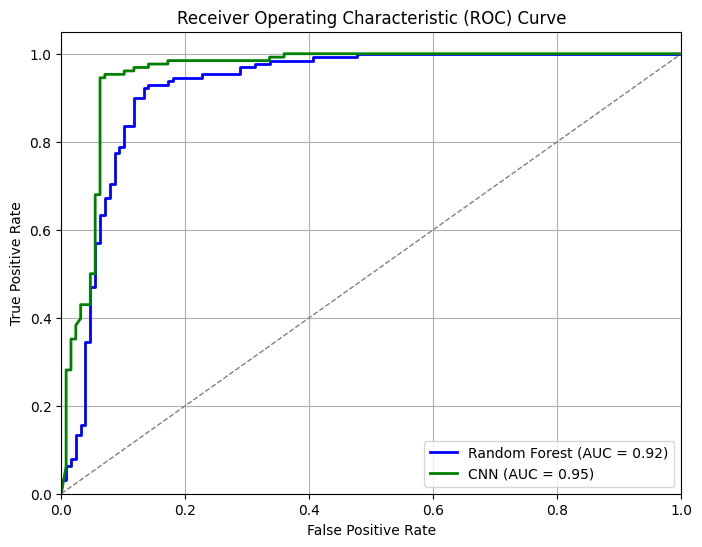

In [33]:
#PLotting ROC curve and AUC

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_cnn, tpr_cnn, _ = roc_curve(test_label_reshaped_cnn, y_proba_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_cnn, tpr_cnn, color='green', lw=2, label=f'CNN (AUC = {roc_auc_cnn:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [34]:
#Saving the best model
cnn_dropout_model.save("../app/model/horse_person_cnn_model.keras")